# ECE 570 Assignment 6 Exercise






Your Name: Sizhe Gao

## Exercise 1: Creating an image denoiser using a CNN autoencoder. (30 points)
In this exercise you are trying to build a autoencoder with CNN layers that can denoise images. 

### Task 1: Create additive noise transform
1. Add code to `AddGaussianNoise` transform class that will:
  * Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, i.e $ \epsilon \sim N(0, 0.3)$.
  * Clip the values to be between 0 and 1 again as they may be outside the range for pixel values after adding Gaussian noise.
2. Plot the first 3 training images and their noisy counterparts in a 2x3 subplot with appropriate titles, figure size, label, etc.

In this task, we concatenate the original dataset and noisy dataset and get a single dataloader. You should be careful with what you load at each iteration. In a more general case, there are many ways of dealing with multiple datasets. For example, you can create separate dataloaders and use ``zip`` to load samples from them. Here is a post discussing how to use ``zip`` [https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1](https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1). 

In [1]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np

class AddGaussianNoise(object):
  ###########################   <YOUR CODE>  ############################
  def __init__(self, mean=0., std=0.3):
    self.mean = mean
    self.std = std
  def __call__(self, tensor):
    temp = tensor + torch.randn(tensor.size()) * self.std + self.mean
    ret = np.clip(temp, 0, 1)
    return ret
  def __repr__(self):
    return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

  #########################  <END YOUR CODE>  ############################


transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(torch.max(train_dataset_noisy.__getitem__(0)[0]).item())
print(torch.min(train_dataset_noisy.__getitem__(0)[0]).item())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

1.0
0.0


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


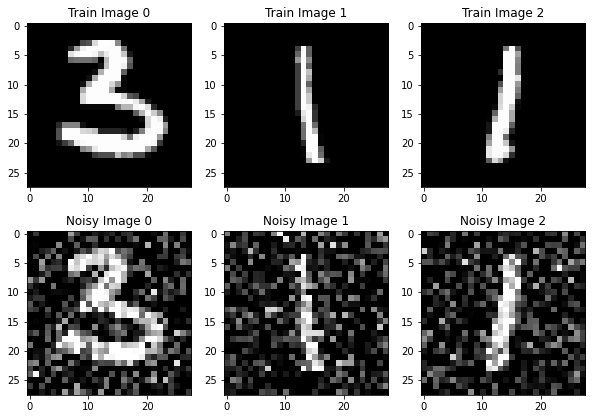

In [2]:
class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i][0] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)


batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

###########################   <YOUR CODE>  ############################
# Plot the first 3 training images with corresponding noisy images 
fig, ax = plt.subplots(2,3)
_, (fliped, original) = next(enumerate(train_loader))
fig.set_size_inches(10,7)
for i in range(3):
  ax[0,i].imshow(original[i][0], cmap='gray')
  ax[0,i].set_title(f'Train Image {i}')
  ax[1,i].imshow(fliped[i][0], cmap='gray')
  ax[1,i].set_title(f'Noisy Image {i}')
fig.show()
#########################  <END YOUR CODE>  ############################

### Task 2: Create and train a denoising autoencoder
1. Build an autoencoder neural network structure with encoders and decoders that is a little more complicated than in the instructions. You can also create the network to have convolutional or transpose convolutional layers. (You can follow the instructions code skeleton with a key difference of using convolutional layers).
2. Move your model to GPU so that you can train your model with GPU. (This step can be simultaneously implemented in the above step)
3. Train your denoising autoencoder model with appropriate optimizer and **MSE** loss function. The loss function should be computed between the output of the noisy images and the clean images, i.e., $L(x, g(f(\tilde{x})))$, where $\tilde{x} = x + \epsilon$ is the noisy image and $\epsilon$ is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value. **Note: Your loss on the test data should be lower than 20.** You may have to experiment with various model architectures to achieve this test loss.
4. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

We are using device name "cuda"
Epoch 1: [0/60000] Loss: 144.8470916748047
Epoch 1: [6400/60000] Loss: 118.62062072753906
Epoch 1: [12800/60000] Loss: 105.40731811523438
Epoch 1: [19200/60000] Loss: 97.93748474121094
Epoch 1: [25600/60000] Loss: 88.27688598632812
Epoch 1: [32000/60000] Loss: 82.71992492675781
Epoch 1: [38400/60000] Loss: 74.03887176513672
Epoch 1: [44800/60000] Loss: 66.74484252929688
Epoch 1: [51200/60000] Loss: 62.21022033691406
Epoch 1: [57600/60000] Loss: 57.195892333984375
Test result on epoch 1: Avg loss is 55.01628125
Epoch 2: [0/60000] Loss: 55.983245849609375
Epoch 2: [6400/60000] Loss: 51.54793930053711
Epoch 2: [12800/60000] Loss: 46.456520080566406
Epoch 2: [19200/60000] Loss: 45.31156921386719
Epoch 2: [25600/60000] Loss: 40.42145538330078
Epoch 2: [32000/60000] Loss: 38.098365783691406
Epoch 2: [38400/60000] Loss: 35.553749084472656
Epoch 2: [44800/60000] Loss: 34.51099395751953
Epoch 2: [51200/60000] Loss: 32.34732437133789
Epoch 2: [57600/60000] Loss: 3

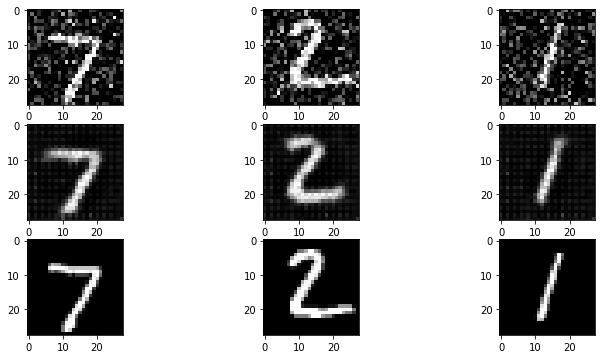

In [3]:
###########################   <YOUR CODE>  ############################
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')

latent_feature = 32

class our_AE(nn.Module):
  def __init__(self):
    super(our_AE, self).__init__()

    # encoder
    self.en_con1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
    self.en_con2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
    self.batch = nn.BatchNorm2d(16)
    self.en_con3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
    self.en_fc1 = nn.Linear(in_features=288, out_features=128)
    self.en_fc2 = nn.Linear(in_features=128, out_features=latent_feature)
    self.flatten = nn.Flatten(start_dim=1)
    # decoder
    self.de_fc1 = nn.Linear(in_features=latent_feature, out_features=128)
    self.de_fc2 = nn.Linear(in_features=128, out_features=288)
    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
    self.de_con1 = nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0)
    self.batch1 = nn.BatchNorm2d(16)
    self.de_con2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
    self.batch2 = nn.BatchNorm2d(8)
    self.de_con3 = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)

  def forward(self, x):

    # encoding layers
    x = F.relu(self.en_con1(x))
    x = F.relu(self.batch(self.en_con2(x)))
    x = F.relu(self.en_con3(x))
    x = self.flatten(x)
    x = F.relu(self.en_fc1(x)) 
    x = self.en_fc2(x)

    # decoding layers
    x = F.relu(self.de_fc1(x))
    x = F.relu(self.de_fc2(x))
    x = self.unflatten(x)
    x = F.relu(self.batch1(self.de_con1(x)))
    x = F.relu(self.batch2(self.de_con2(x)))
    x = self.de_con3(x)
    x = torch.sigmoid(x)
    
    return x


AE = our_AE().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='sum')

def train(epoch, device):

  AE.train() # we need to set the mode for our model

  for batch_idx, (images, original) in enumerate(train_loader): # Note that we do not need the labels

    optimizer.zero_grad()
    images = images.float()
    images = images.to(device)
    original = original.to(device)
    output = AE(images)
    loss = loss_fn(output, original) # Here is a typical loss function (Mean square error)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  AE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, original in test_loader:
      images = images.float()
      images = images.to(device)
      original = original.to(device)
      output = AE(images)
      test_loss += loss_fn(output, original).item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 4
for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)
  
batch_idx, (images, original) = next(enumerate(test_loader))
images = images.to(device)
output = AE(images).cpu().detach()
images = images.cpu()

print(images.size(), output.size())

fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,6)

for idx in range(3):
  ax[0,idx].imshow(images[idx][0], cmap='gray')
  ax[1,idx].imshow(output[idx][0], cmap='gray')
  ax[2,idx].imshow(original[idx][0], cmap='gray')

fig.show()

#########################  <END YOUR CODE>  ############################

## Exercise 2: Build a variational autoencoder(VAE) that can generate MNIST images (70 points)

### Task 0: Setup
1. Import necessary packages
2. Load the MNIST data as above.
3. Specify the device.

In [4]:
###########################   <YOUR CODE>  ############################
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load data from 
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

# Set Device
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')



#########################  <END YOUR CODE>  ############################

We are using device name "cuda"


### Task 1: VAE Loss function
Construct your loss function. The loss function for VAE is a little bit difficult:
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
In this exercise, you will build the VAE (variational autoencoder) model satisfying following conditions which simplifies the computation of loss function:
1. $p_g(z)$ is a standard normal distribution.
2. $q_f(z|x)$ is a multivariate Gaussian with trainable mean and variance along each dimension.
3. The output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.

While we discussed the Gaussian distribution in class, here we assume the output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.
The value of the pixel corresponds to the average of the Bernoulli distribution.
This loss can be seen in Appendix C.1 of the original VAE paper: https://arxiv.org/pdf/1312.6114.pdf.
With such assumpition, the reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
See [torch.nn.functional.binary_cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy).
You should use the sum reduction of the loss to sum the loss over all the pixels. 

The second part is the KL-Divergence between your model's approximate posterier $q_f(z|x)$ and the model prior $p_g(z)$.
If we assume $p_g(z)$ is a standard normal distribution and $q_f(z|x)$ is a Gaussian with unknown mean and variance, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above):
$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2)$. 


Your task here is to write a function `vae_loss` that takes the value of your model's output, the original images, mu, and log_var (i.e., the $\log(\sigma_j^2)$ term), and returns the the reconstruction loss and the KL loss terms **separately** (i.e., the function should return two loss arrays). To visualize these losses separately in a later task, you will need the reconstruction loss and KL loss separated.


In [5]:
def vae_loss(output, mu, log_var, images):
  """
  :param output: this the output of your neural network
  :param mu: this is the mu from the latent space
  :param log_var: this is the log_var from the latent space
  :param images: this is the original sets of images
  """
  ###########################   <YOUR CODE>  ############################
  #output = output.to("cpu")
  #images = images.to("cpu")
  loss = F.binary_cross_entropy(output, images, reduction = 'sum')

  # KL part
  temp = 1 + log_var - mu*mu - log_var.exp()
  kld = torch.sum(temp).mul(-0.5)
  return loss, kld

  #########################  <END YOUR CODE>  ############################


### Task 2: VAE model
Build the VAE (variational autoencoder) model based on the instructions given below and in the comments.
* Inside the `reparameterize` function you job is to output a latent vector. You should first calculate the standard deviation `std` from the log variance variable `log_var` (i.e., compute $\sigma$ from $\log (\sigma^2)$, then generate the vector in Gaussian distribution with `mu` and `std`.  **Importantly**, this should use the reparametrization trick so that we can backpropagate through this random step.

* Inside the `forward` function you should extract the `mu` and `log_var` from the latent representation after the encoder. The output of encoder should be in the dimension ` [batch_size x 2 x latent_feature]`, which includes a mean and log variance for each latent feature and for each instance in the batch.  Remember that in VAEs, the encoder outputs the parameters of the latent distribution. Note that the second dimension has value 2, so you need to split this tensor into two components, one called `mu` and the other called `log_var`---which will be fed into reparameterize.



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class our_VAE(nn.Module):
  def __init__(self, latent_feature = 16): # you can use any number of latent features you want in the training
    super(our_VAE, self).__init__()

    self.latent_feature = latent_feature

    ###########################   <YOUR CODE>  ############################
    # define the transformations for your encoder and decoder

    # encoder
    self.en_fc1 = nn.Linear(in_features=784, out_features=512)
    self.en_fc2 = nn.Linear(in_features=512, out_features=latent_feature)
    self.en_fc3 = nn.Linear(in_features=512, out_features=latent_feature)
    # decoder
    self.de_fc1 = nn.Linear(in_features=latent_feature, out_features=512)
    self.de_fc2 = nn.Linear(in_features=512, out_features=784)

    #########################  <END YOUR CODE>  ############################

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var) using 
    the reparameterization trick.
    """
    ###########################   <YOUR CODE>  ############################
    std = log_var.mul(0.5).exp_()
    nor = torch.normal(0, 1, size = std.shape)
    nor = nor.to(device)
    sample = nor.mul(std).add(mu)

    #########################  <END YOUR CODE>  ############################
    return sample
  def encoder(self, x):
    """
    :param x: input distribution

    You should first compute the parameters mu and log_var for Gaussian distribution q(z|x), and 
    then get samples from q(z|x) using the reparameterize function you just created.
    The final output should include mu, log_var and z~q(z|x)
    """
    ###########################   <YOUR CODE>  ############################
    x = x.view(-1, 784)
    t = F.relu(self.en_fc1(x))
    mu = self.en_fc2(t)
    log_var = self.en_fc3(t)
    z = self.reparameterize(mu, log_var)

    #########################  <END YOUR CODE>  ###########################
    return mu, log_var, z

  def decoder(self, z):
    """
    :param z: latent distribution

    You should compute the output x given latent samples z
    """

    ###########################   <YOUR CODE>  ############################
    x = F.relu(self.de_fc1(z))
    x = F.sigmoid(self.de_fc2(x))
    x = x.view(-1, 1, 28, 28)
    x = torch.clip(x, 0, 1)
    #########################  <END YOUR CODE>  ###########################
    return x


  
  def forward(self, x):
    """
    :param x: input variables

    You should compute the output images using the encoder and decoder you just defined.
    Remember to return the mu and log_var for the computation of loss.
    """

    ###########################   <YOUR CODE>  ############################
    mu, log_var, z = self.encoder(x)
    x = self.decoder(z)

    #########################  <END YOUR CODE>  ###########################

    
    return x, mu, log_var

### Task 3: Train and visualize output
1. Train your model with an appropriate optimizer and the above loss function. You should train your model with enough epochs so that your loss reaches a relatively steady value.

2. Visualize your result. You should **show three pairs of images** where each pair consists of an original test image and its VAE reconstructed version.

3. Keep track of the loss. You should save the negative ELBO, Reconstruction Loss and KL Divergence Loss after every 10 batches in the trainining and **create a plot with three curves** using [matplotlib.pyplot.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). Each curve should correpond to one of the losses. The x-axis will be the number of batches divided by 10 and the y-axis will be the loss. **Make sure you clearly specify the legend, x-label and y-label.**

**Note:** It is always a good idea to keep track of the loss in the process of training to help you understand what is happening during training.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1: [0/60000] Loss: 549.1857299804688
Epoch 1: [6400/60000] Loss: 200.39918518066406
Epoch 1: [12800/60000] Loss: 167.85975646972656
Epoch 1: [19200/60000] Loss: 151.51705932617188
Epoch 1: [25600/60000] Loss: 145.28736877441406
Epoch 1: [32000/60000] Loss: 132.2953338623047
Epoch 1: [38400/60000] Loss: 131.58935546875
Epoch 1: [44800/60000] Loss: 126.82638549804688
Epoch 1: [51200/60000] Loss: 133.61184692382812
Epoch 1: [57600/60000] Loss: 129.06100463867188


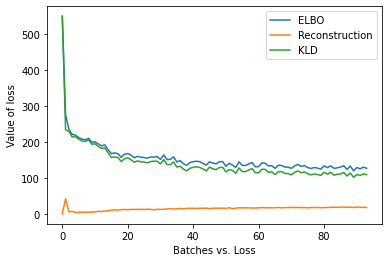

Test result on epoch 1: Avg loss is 126.60694885253906
Epoch 2: [0/60000] Loss: 132.82070922851562
Epoch 2: [6400/60000] Loss: 130.05967712402344
Epoch 2: [12800/60000] Loss: 124.27928924560547
Epoch 2: [19200/60000] Loss: 122.94026947021484
Epoch 2: [25600/60000] Loss: 121.56440734863281
Epoch 2: [32000/60000] Loss: 121.7016372680664
Epoch 2: [38400/60000] Loss: 121.63544464111328
Epoch 2: [44800/60000] Loss: 117.64395141601562
Epoch 2: [51200/60000] Loss: 123.68334197998047
Epoch 2: [57600/60000] Loss: 124.37718200683594


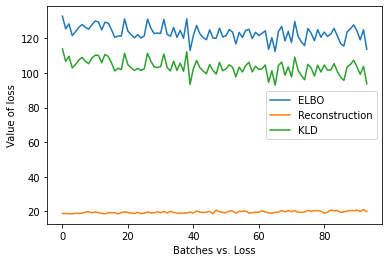

Test result on epoch 2: Avg loss is 119.6141357421875
Epoch 3: [0/60000] Loss: 131.41656494140625
Epoch 3: [6400/60000] Loss: 123.21780395507812
Epoch 3: [12800/60000] Loss: 107.43465423583984
Epoch 3: [19200/60000] Loss: 123.82757568359375
Epoch 3: [25600/60000] Loss: 117.29022216796875
Epoch 3: [32000/60000] Loss: 115.54345703125
Epoch 3: [38400/60000] Loss: 117.40555572509766
Epoch 3: [44800/60000] Loss: 116.12362670898438
Epoch 3: [51200/60000] Loss: 118.58817291259766
Epoch 3: [57600/60000] Loss: 117.75738525390625


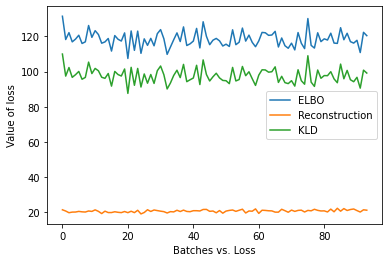

Test result on epoch 3: Avg loss is 116.260498046875
Epoch 4: [0/60000] Loss: 119.20706939697266
Epoch 4: [6400/60000] Loss: 122.45553588867188
Epoch 4: [12800/60000] Loss: 113.91202545166016
Epoch 4: [19200/60000] Loss: 120.06840515136719
Epoch 4: [25600/60000] Loss: 115.23979949951172
Epoch 4: [32000/60000] Loss: 121.0977783203125
Epoch 4: [38400/60000] Loss: 117.88163757324219
Epoch 4: [44800/60000] Loss: 112.30347442626953
Epoch 4: [51200/60000] Loss: 115.51480102539062
Epoch 4: [57600/60000] Loss: 110.82505798339844


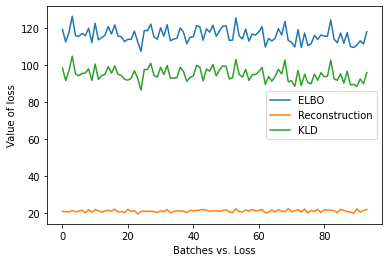

Test result on epoch 4: Avg loss is 114.95475769042969


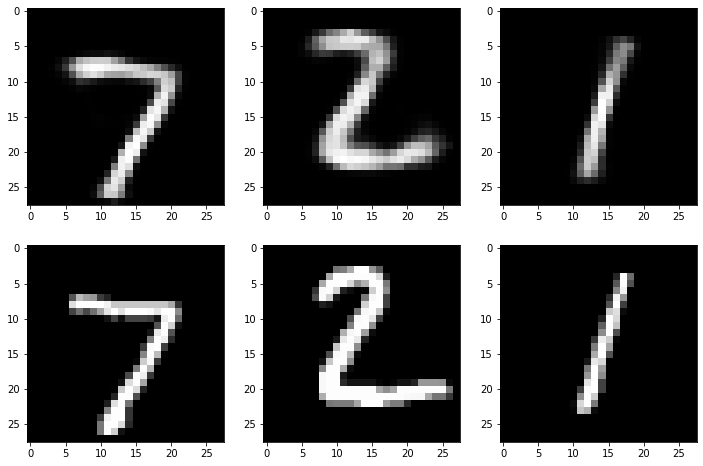

In [8]:
###########################   <YOUR CODE>  ############################
VAE = our_VAE().to(device)
optimizer = optim.Adam(VAE.parameters(), lr=0.001, weight_decay=1e-05)


def train(epoch, device):

  VAE.train() # we need to set the mode for our model

  for batch_idx, (images, original) in enumerate(train_loader): # Note that we do not need the labels

    optimizer.zero_grad()
    images = images.to(device)
    original = original.to(device)
    output, mu, log_var = VAE(images)
    loss, KLD = vae_loss(output, mu, log_var, original) # Here is a typical loss function (Mean square error)
    elbo = loss + KLD
    elbo.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_elbo.append(elbo.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_loss.append(loss.item()/batch_size_train)
      train_kld.append(KLD.item()/batch_size_train)
      train_idx.append(batch_idx / 10)
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {elbo.item()/batch_size_train}')

  loss_f = plt.figure(1)
  plt.plot(train_idx,train_elbo, label = "ELBO")
  plt.plot(train_idx,train_kld, label = "Reconstruction")
  plt.plot(train_idx,train_loss, label = "KLD")
  plt.xlabel("Batches vs. Loss")
  plt.ylabel("Value of loss")
  plt.legend()
  plt.show()


def test(epoch, device):

  VAE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, original in test_loader:
      images = images.float()
      images = images.to(device)
      original = original.to(device)
      output, mu, log_var = VAE(images)
      loss, kld = vae_loss(output, mu, log_var, original)
      elbo = loss + kld
      test_loss += elbo
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

train_losses = []
train_counter = []
test_losses = []
test_counter = []

max_epoch = 4
for epoch in range(1, max_epoch+1):
  train_elbo = []
  train_loss = []
  train_kld = []
  train_idx = []
  train(epoch, device=device)
  test(epoch, device=device)

VAE.eval()
_, (noise, original)  = next(enumerate(test_loader))
noise = noise.to(device)
output, mu, log_var = VAE(noise)
output = output.detach().to('cpu')
noise = noise.cpu().detach()

fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,8)

for idx in range(3):
  ax[0,idx].imshow(output[idx][0], cmap='gray')
  ax[1,idx].imshow(original[idx][0], cmap='gray')
fig.show()

# loss_f = plt.figure(2)
# plt.plot(train_idx,train_elbo, label = "ELBO")
# plt.plot(train_idx,train_kld, label = "Reconstruction")
# plt.plot(train_idx,train_loss, label = "KLD")
# plt.xlabel("Batches vs. Loss")
# plt.ylabel("Value of loss")
# plt.legend()
# plt.show()

# plt.plot(train_idx,train_elbo, label = "ELBO")
# plt.plot(train_idx,train_kld, label = "Reconstruction")
# plt.plot(train_idx,train_loss, label = "KLD")
# plt.xlabel("Batches")
# plt.ylabel("Value of loss")
# plt.legend()
# plt.show()

#########################  <END YOUR CODE>  ###########################


### Task 4.1: Latent space of VAE

The latent space will change over time during training as the networks learn which features of the input are most important.  In the beginning, the reconstruction error will be poor and the latent space will be mixed up (i.e., it has not identified good features for dimensionality reduction and then reconstruction).  However, as it continues to train, the space will begin to show some structure (similar to in PCA) as it finds features that enable good reconstruction even after adding a little noise. Therefore, to get some intuition about this process, in this task, you will visualize how latent space changes in the process of training with the given function ``plot_latent``.

1. For better visualization, create a VAE with ``latent_features=2``.
2. Similar to task 3, train the VAE for a few epochs. But you will need to plot the latent distribution using the provided ``plot_latent`` function below at initialization (so you can see what the latent space looks like at initialization) AND after **each** epoch. You should use the **test** data for plotting this visualization task.


In [12]:
def plot_latent(vae, data_loader, num_batches=2):
  with torch.no_grad():
    for ibx, (images,label) in enumerate(data_loader):
      _,_,z = vae.encoder(label.to(device))
      z = z.to('cpu').detach().numpy()
      plt.scatter(z[:, 0], z[:, 1], c=label[:,0,0,0], cmap='tab10',s=1)
      if ibx > num_batches:
        break
  plt.colorbar()
  plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1: [0/60000] Loss: 548.2465209960938
Epoch 1: [6400/60000] Loss: 180.43397521972656
Epoch 1: [12800/60000] Loss: 180.375244140625
Epoch 1: [19200/60000] Loss: 171.94113159179688
Epoch 1: [25600/60000] Loss: 174.01113891601562
Epoch 1: [32000/60000] Loss: 169.91925048828125
Epoch 1: [38400/60000] Loss: 168.43655395507812
Epoch 1: [44800/60000] Loss: 156.9003448486328
Epoch 1: [51200/60000] Loss: 165.8216552734375
Epoch 1: [57600/60000] Loss: 162.62350463867188
Test result on epoch 1: Avg loss is 163.9440155029297


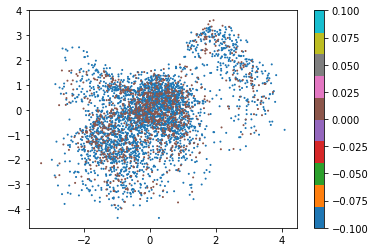

In [13]:
###########################   <YOUR CODE>  ############################
class other_VAE(nn.Module):
  def __init__(self, latent_feature = 2): # you can use any number of latent features you want in the training
    super(other_VAE, self).__init__()

    self.latent_feature = latent_feature

    ###########################   <YOUR CODE>  ############################
    # define the transformations for your encoder and decoder

    # encoder
    self.en_fc1 = nn.Linear(in_features=784, out_features=512)
    self.en_fc2 = nn.Linear(in_features=512, out_features=latent_feature)
    self.en_fc3 = nn.Linear(in_features=512, out_features=latent_feature)
    # decoder
    self.de_fc1 = nn.Linear(in_features=latent_feature, out_features=512)
    self.de_fc2 = nn.Linear(in_features=512, out_features=784)

    #########################  <END YOUR CODE>  ############################

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var) using 
    the reparameterization trick.
    """
    ###########################   <YOUR CODE>  ############################
    std = log_var.mul(0.5).exp_()
    nor = torch.normal(0, 1, size = std.shape)
    nor = nor.to(device)
    sample = nor.mul(std).add(mu)

    #########################  <END YOUR CODE>  ############################
    return sample
  def encoder(self, x):
    """
    :param x: input distribution

    You should first compute the parameters mu and log_var for Gaussian distribution q(z|x), and 
    then get samples from q(z|x) using the reparameterize function you just created.
    The final output should include mu, log_var and z~q(z|x)
    """
    ###########################   <YOUR CODE>  ############################
    x = x.view(-1, 784)
    t = F.relu(self.en_fc1(x))
    mu = self.en_fc2(t)
    log_var = self.en_fc3(t)
    z = self.reparameterize(mu, log_var)

    #########################  <END YOUR CODE>  ###########################
    return mu, log_var, z

  def decoder(self, z):
    """
    :param z: latent distribution

    You should compute the output x given latent samples z
    """

    ###########################   <YOUR CODE>  ############################
    x = F.relu(self.de_fc1(z))
    x = F.sigmoid(self.de_fc2(x))
    x = x.view(-1, 1, 28, 28)
    x = torch.clip(x, 0, 1)
    #########################  <END YOUR CODE>  ###########################
    return x


  
  def forward(self, x):
    """
    :param x: input variables

    You should compute the output images using the encoder and decoder you just defined.
    Remember to return the mu and log_var for the computation of loss.
    """

    ###########################   <YOUR CODE>  ############################
    mu, log_var, z = self.encoder(x)
    x = self.decoder(z)

    #########################  <END YOUR CODE>  ###########################

    
    return x, mu, log_var

#########################  <END YOUR CODE>  ###########################

VAE = other_VAE().to(device)
optimizer = optim.Adam(VAE.parameters(), lr=0.001, weight_decay=1e-05)


def train(epoch, device):

  VAE.train() # we need to set the mode for our model

  for batch_idx, (images, original) in enumerate(train_loader): # Note that we do not need the labels

    optimizer.zero_grad()
    images = images.to(device)
    original = original.to(device)
    output, mu, log_var = VAE(original)
    loss, KLD = vae_loss(output, mu, log_var, original) # Here is a typical loss function (Mean square error)
    elbo = loss + KLD
    elbo.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_elbo.append(elbo.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_loss.append(loss.item()/batch_size_train)
      train_kld.append(KLD.item()/batch_size_train)
      train_idx.append(batch_idx / 10)
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {elbo.item()/batch_size_train}')


def test(epoch, device):

  VAE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, original in test_loader:
      images = images.float()
      images = images.to(device)
      original = original.to(device)
      output, mu, log_var = VAE(original)
      loss, kld = vae_loss(output, mu, log_var, original)
      elbo = loss + kld
      test_loss += elbo
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

train_losses = []
train_counter = []
test_losses = []
test_counter = []

max_epoch = 1
for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)
  plot_latent(VAE, test_loader, num_batches=2)

### Task 4.2 Interpolation of latent space

Interpolation can be quite useful for autoencoder models. For example, by linearly interpolating (or mixing) codes in latent space and decoding the result, the autoencoder can produce a more **semantically meaningful**
combination of the corresponding datapoints than linear interpolation in the raw pixel space. 
Besides, in some cases, interpolation experiments can show that the model has learned a latent space with a particular structure. Specifically, if interpolation between points in the latent space shows a smooth semantic warping in the original image space, then the visualization may suggest that similar points are semantically clustered in the latent space.

In this task, you will do a simple experiment to see the difference between linear interpolation in the latent space and the original data space (raw pixels).
1. With a trained model and test data, sample one $z\sim q(z|x)$ corresponding to label 0 and 1 separately (two samples in total); this can be done by passing test samples (with labels 0 and 1 respectively) through the encoder. These two latent samples will be denoted $z_0$ and $z_1$ respectively.

2. Compute the linear interpolation of $x_0$ and $x_1$ in the following way: $x'=\alpha x_1 + (1-\alpha)x_0$ where $\alpha = 0, 0.1, 0.2, \dots, 0.9, 1.0$. **Plot** all $x'$ images you get in a 1x11 grid.

3. Compute the latent linear interpolation of $z_0$ and $z_1$ to get $z'$ in a similar way. Then, reconstruct the $x'$ corresponding to each $z'$ using the decoder. **Plot** all $x'$ images you get in a 1x11 grid.

In [ ]:
###########################   <YOUR CODE>  ############################

#########################  <END YOUR CODE>  ###########################